# Conditioning and Guidance 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import DataLoader
from smalldiffusion import TreeDataset, training_loop, samples, ScheduleLogLinear, ConditionalMLP
from torch.utils.data import Dataset
from itertools import pairwise
from pathlib import Path
from tqdm import tqdm

def plot_batch(batch, ax=None, **kwargs):
    batch = batch.cpu().numpy()
    ax = ax or plt
    return ax.scatter(batch[:,0], batch[:,1], marker='.', **kwargs)
    
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w   

class MultiClassSwissroll(Dataset):
    def __init__(self, tmin, tmax, N, num_classes=10, center=(0,0), scale=1.0):

        self.num_classes = num_classes
        
        t = tmin + torch.linspace(0, 1, N) * tmax
        center = torch.tensor(center).unsqueeze(0)
        spiral_points = center + scale * torch.stack([t*torch.cos(t)/tmax, t*torch.sin(t)/tmax]).T
        
        # Assign classes based on position along the spiral
        # Divide the parameter range into num_classes segments
        class_boundaries = torch.linspace(tmin, tmax, num_classes + 1)
        classes = torch.zeros(N, dtype=torch.long)
        
        for i in range(N):
            # t[i] is already the actual parameter value we want to use for class assignment
            t_val = t[i]
            # Find which segment t_val falls into (0 to num_classes-1)
            class_idx = min(int((t_val - tmin) / (tmax - tmin) * num_classes), num_classes - 1)
            classes[i] = class_idx
        
        # Store data as list of (point, class) tuples
        self.data = [(spiral_points[i], classes[i].item()) for i in range(N)]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def get_class_colors(self):
        """
        Returns a list of colors evenly sampled from a colorwheel (HSV space).
        """
        import matplotlib.colors as mcolors
        
        # Generate evenly spaced hues around the color wheel
        hues = np.linspace(0, 1, self.num_classes, endpoint=False)
        colors = []
        
        for hue in hues:
            # Convert HSV to RGB (saturation=1, value=1 for vibrant colors)
            rgb = mcolors.hsv_to_rgb([hue, 1.0, 1.0])
            colors.append(rgb)
        
        return colors


In [2]:
dataset = MultiClassSwissroll(np.pi/2, 5*np.pi, 100, num_classes=3)
colors = dataset.get_class_colors()
loader = DataLoader(dataset, batch_size=len(dataset)*2, shuffle=True)

In [3]:
x, labels = next(iter(loader))
x=x.cpu().numpy()

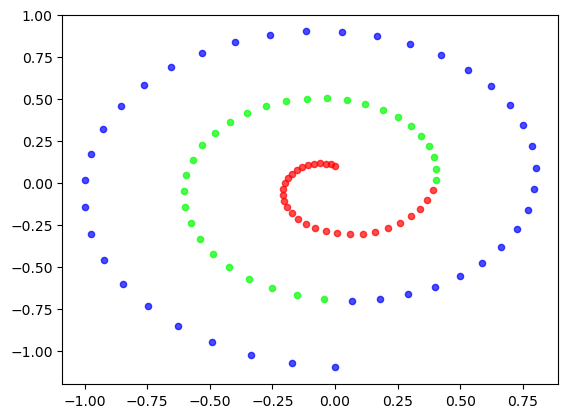

In [4]:
for class_idx in range(dataset.num_classes):
    mask = labels == class_idx
    class_points = x[mask]
    plt.scatter(class_points[:, 0], class_points[:, 1], 
               c=[colors[class_idx]], label=f'Class {class_idx}', 
               alpha=0.7, s=20)

In [5]:
model = ConditionalMLP(dim=2, hidden_dims=(16, 128, 256, 128, 16), cond_dim=4, num_classes=dataset.num_classes)
schedule = ScheduleLogLinear(N=200, sigma_min=0.01, sigma_max=10)
trainer = training_loop(loader, model, schedule, epochs=30000, lr=1e-3, conditional=True)
losses = [ns.loss.item() for ns in trainer]

100%|███████████████████████| 30000/30000 [04:40<00:00, 106.77it/s]


In [6]:
bound=1.5
num_heatmap_steps=30
grid=[]
for i, x in enumerate(np.linspace(-bound, bound, num_heatmap_steps)):
    for j, y in enumerate(np.linspace(-bound, bound, num_heatmap_steps)):
        grid.append([x,y])
grid=torch.tensor(grid).float()

In [10]:
# Generalizes most commonly-used samplers:
#   DDPM       : gam=1, mu=0.5
#   DDIM       : gam=1, mu=0
#   Accelerated: gam=2, mu=0

N_sample=64 #Crank to 256 for nice viz? I guess I'll probably be re-doing this on the manim side, so I can crank there
sample_batch_size=100
gam=1.0
cfg_scale=0.0 # 0 means no classifier-free guidance
mu=0.0
batchsize=sample_batch_size

results_by_class=[]
xt_history=[]
heatmaps=[]
unconditioned_heatmaps=[]
conditioned_heatmaps=[]
cfg_scales=[0.0, 0.1, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0]
c=2 #Just hack on a single class for now

sigmas=schedule.sample_sigmas(N_sample)
x_init = model.rand_input(batchsize).to('cuda') * sigmas[0]

for cfg_scale in cfg_scales:
    cond=torch.tensor([c for _ in range(sample_batch_size)])
    cond_grid=torch.tensor([c for _ in range(len(grid))])
    xt_history.append([])
    heatmaps.append([])
    unconditioned_heatmaps.append([])
    conditioned_heatmaps.append([])
    with torch.no_grad():
        model.eval()
        # xt = model.rand_input(batchsize).to('cuda') * sigmas[0]
        xt=x_init.clone()
        if cond is not None:
            assert cond.shape[0] == xt.shape[0], 'cond must have same shape as x!'
            cond = cond.to(xt.device)
        eps = None
        for i, (sig, sig_prev) in enumerate(pairwise(sigmas)):
            eps_prev, eps = eps, model.predict_eps_cfg(xt, sig.to(xt), cond, cfg_scale)
            eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps
            sig_p = (sig_prev/sig**mu)**(1/(1-mu)) # sig_prev == sig**mu sig_p**(1-mu)
            eta = (sig_prev**2 - sig_p**2).sqrt()
            xt = xt - (sig - sig_p) * eps_av + eta * model.rand_input(xt.shape[0]).to(xt)
            
            xt_history[-1].append(xt.cpu().numpy())
            # heatmaps[-1].append(model.forward(grid, sig.to('cuda'), cond=cond))
            heatmaps[-1].append(model.predict_eps_cfg(grid.to('cuda'), sig.to(xt), cond_grid.to('cuda'), cfg_scale).cpu())

            #Uncoditioned and conditioned heatmaps let's go!
            uncond = torch.full_like(cond_grid.to('cuda'), model.cond_embed.null_cond) # (B,)
            eps_cond, eps_uncond = model.predict_eps(                  # (B,), (B,)
                torch.cat([grid.to('cuda'), grid.to('cuda')]), sig.to(xt), torch.cat([cond_grid.to('cuda'), uncond])   # (2B,)
            ).chunk(2)
            unconditioned_heatmaps[-1].append(eps_uncond.cpu())
            conditioned_heatmaps[-1].append(eps_cond.cpu())

    xt_history[-1]=np.array(xt_history[-1])
    results_by_class.append(xt.cpu().numpy())

In [77]:
colors24 = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'gray', 'pink', 'olive', 'cyan', 'magenta', 'black', 'aqua',  'yellow', 'navy', 'maroon', 'lime', 'teal', 'silver', 'fuchsia', 'indigo', 'crimson', 'gold', 'coral']

In [78]:
save_dir=Path('/home/stephen/sora/jun_24_1')
save_dir.mkdir(exist_ok=True)

In [79]:
heatmap_mask=np.zeros((30,30), dtype=bool)
heatmap_mask[10:20, 10:20]=1.0

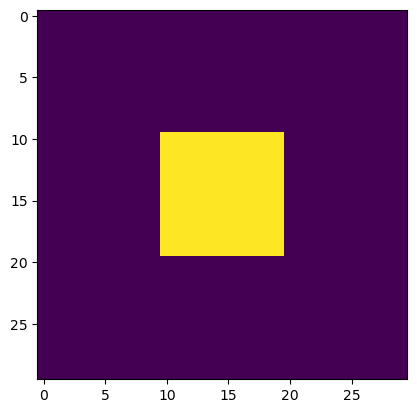

In [80]:
plt.imshow(heatmap_mask)

In [81]:
len(heatmaps)

8

In [82]:
len(heatmaps[0])

64

In [83]:
xt_history[0].shape

(64, 100, 2)

<Figure size 640x480 with 0 Axes>

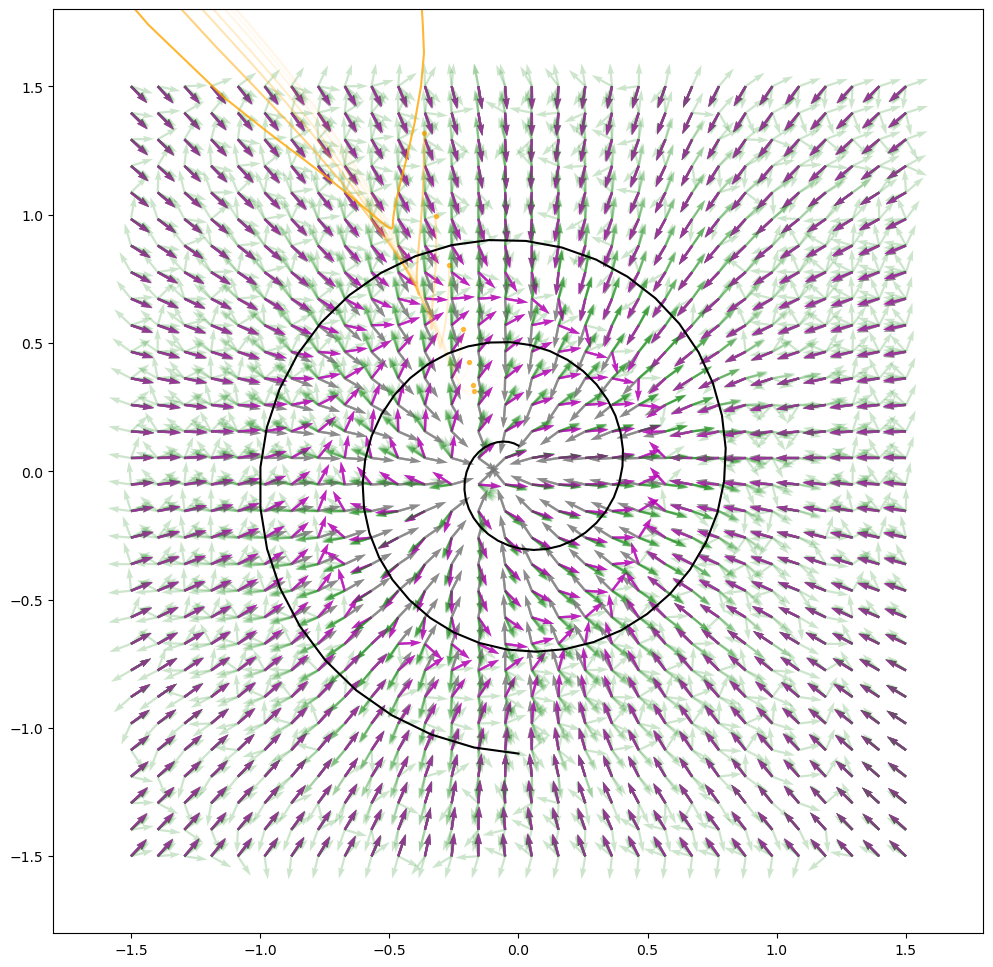

In [109]:
#Let's try different guidance levels sequentiall first.
count=0
# for i in tqdm(range(len(heatmaps[0]))):
i=27
plt.clf()
fig=plt.figure(0, (12,12))

for j, cfg_scale in enumerate(cfg_scales):
    masked_map=torch.nn.functional.normalize(heatmaps[j][i], p=2, dim=1)
    # heatmap_norm=heatmaps[j][i] #*heatmap_mask
    # masked_map=(heatmaps[j][i].reshape(30,30,2)*torch.tensor(heatmap_mask).unsqueeze(-1).repeat(1, 1, 2))
    # masked_map=masked_map.view(900,2)
    plt.quiver(grid[:,0], grid[:,1], -masked_map[:,0], -masked_map[:,1], alpha=0.2,  scale=40, color='g')

    masked_map=torch.nn.functional.normalize(unconditioned_heatmaps[j][i], p=2, dim=1)
    # heatmap_norm=unconditioned_heatmaps[j][i] #*heatmap_mask
    # masked_map=(unconditioned_heatmaps[j][i].reshape(30,30,2)*torch.tensor(heatmap_mask).unsqueeze(-1).repeat(1, 1, 2))
    # masked_map=masked_map.view(900,2)
    plt.quiver(grid[:,0], grid[:,1], -masked_map[:,0], -masked_map[:,1], alpha=0.2,  scale=40, color='#777777')

    masked_map=torch.nn.functional.normalize(conditioned_heatmaps[j][i], p=2, dim=1)
    # heatmap_norm=conditioned_heatmaps[j][i] #*heatmap_mask
    # masked_map=(conditioned_heatmaps[j][i].reshape(30,30,2)*torch.tensor(heatmap_mask).unsqueeze(-1).repeat(1, 1, 2))
    # masked_map=masked_map.view(900,2)
    plt.quiver(grid[:,0], grid[:,1], -masked_map[:,0], -masked_map[:,1], alpha=0.2,  scale=40, color='m')

    for k in [75]: #range(75, 80): #Just do a subset of trajetories
        # plt.plot(xt_history[j][np.maximum(i-10, 0):i+1,k,0], xt_history[j][np.maximum(i-10, 0):i+1,k,1], '-', alpha=0.2, color=tuple(colors[c]))
        plt.plot(xt_history[j][:i+1,k,0], xt_history[j][:i+1,k,1], '-', alpha=np.clip(cfg_scale/10, 0.05, 0.8), color=colors24[k%24])
        plt.scatter(xt_history[j][i,k,0], xt_history[j][i,k,1], alpha=0.7, s=8, c=colors24[k%24])

data_raw=np.array([o[0].numpy() for o in dataset.data])
plt.plot(data_raw[:,0], data_raw[:,1], c='k')

viz_bounds=1.8
plt.xlim([-viz_bounds, viz_bounds]);  plt.ylim([-viz_bounds, viz_bounds])
plt.savefig(save_dir/(str(count)+'.png'), dpi=200)
count+=1

/tmp/ipykernel_45559/773835901.py:6: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0, (12,12))
100%|██████████████████████████████| 64/64 [01:25<00:00,  1.34s/it]


<Figure size 640x480 with 0 Axes>

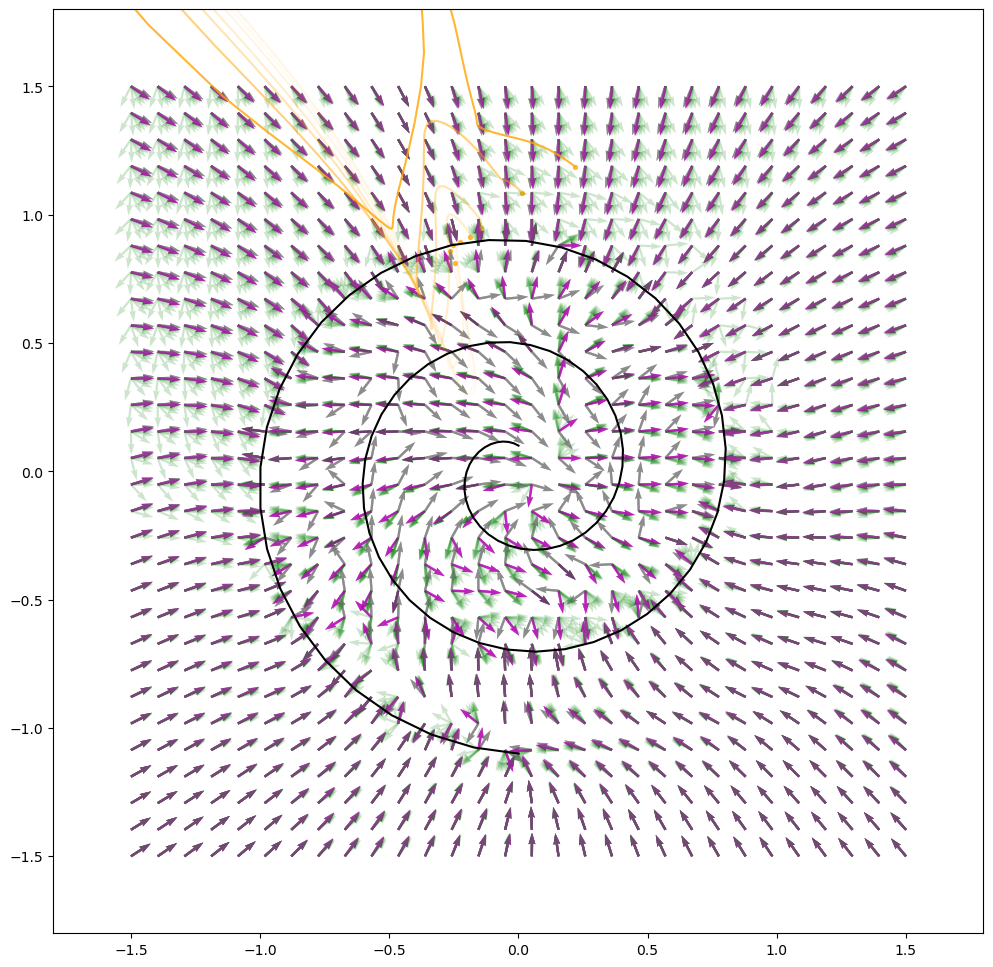

In [107]:
#Let's try different guidance levels sequentiall first.
count=0
for i in tqdm(range(len(heatmaps[0]))):
# i=25
    plt.clf()
    fig=plt.figure(0, (12,12))

    for j, cfg_scale in enumerate(cfg_scales):
        masked_map=torch.nn.functional.normalize(heatmaps[j][i], p=2, dim=1)
        # heatmap_norm=heatmaps[j][i] #*heatmap_mask
        # masked_map=(heatmaps[j][i].reshape(30,30,2)*torch.tensor(heatmap_mask).unsqueeze(-1).repeat(1, 1, 2))
        # masked_map=masked_map.view(900,2)
        plt.quiver(grid[:,0], grid[:,1], -masked_map[:,0], -masked_map[:,1], alpha=0.2,  scale=40, color='g')
    
        masked_map=torch.nn.functional.normalize(unconditioned_heatmaps[j][i], p=2, dim=1)
        # heatmap_norm=unconditioned_heatmaps[j][i] #*heatmap_mask
        # masked_map=(unconditioned_heatmaps[j][i].reshape(30,30,2)*torch.tensor(heatmap_mask).unsqueeze(-1).repeat(1, 1, 2))
        # masked_map=masked_map.view(900,2)
        plt.quiver(grid[:,0], grid[:,1], -masked_map[:,0], -masked_map[:,1], alpha=0.2,  scale=40, color='#777777')
    
        masked_map=torch.nn.functional.normalize(conditioned_heatmaps[j][i], p=2, dim=1)
        # heatmap_norm=conditioned_heatmaps[j][i] #*heatmap_mask
        # masked_map=(conditioned_heatmaps[j][i].reshape(30,30,2)*torch.tensor(heatmap_mask).unsqueeze(-1).repeat(1, 1, 2))
        # masked_map=masked_map.view(900,2)
        plt.quiver(grid[:,0], grid[:,1], -masked_map[:,0], -masked_map[:,1], alpha=0.2,  scale=40, color='m')
    
        for k in [75]: #range(75, 80): #Just do a subset of trajetories
            # plt.plot(xt_history[j][np.maximum(i-10, 0):i+1,k,0], xt_history[j][np.maximum(i-10, 0):i+1,k,1], '-', alpha=0.2, color=tuple(colors[c]))
            plt.plot(xt_history[j][:i+1,k,0], xt_history[j][:i+1,k,1], '-', alpha=np.clip(cfg_scale/10, 0.05, 0.8), color=colors24[k%24])
            plt.scatter(xt_history[j][i,k,0], xt_history[j][i,k,1], alpha=0.7, s=8, c=colors24[k%24])
    
    data_raw=np.array([o[0].numpy() for o in dataset.data])
    plt.plot(data_raw[:,0], data_raw[:,1], c='k')
    
    viz_bounds=1.8
    plt.xlim([-viz_bounds, viz_bounds]);  plt.ylim([-viz_bounds, viz_bounds])
    plt.savefig(save_dir/(str(count)+'.png'), dpi=200)
    count+=1

<Figure size 640x480 with 0 Axes>

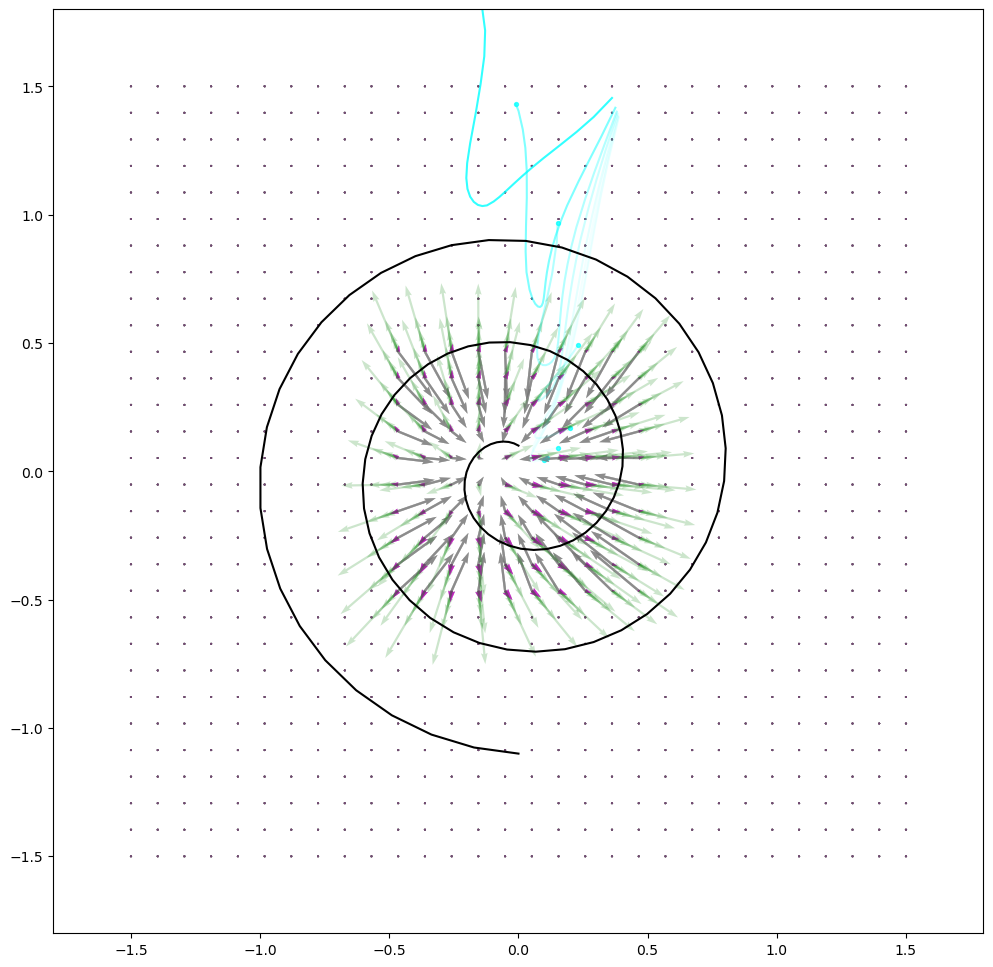

In [92]:
#Let's try different guidance levels sequentiall first.
count=0
# for i in tqdm(range(len(heatmaps[0]))):
i=28
plt.clf()
fig=plt.figure(0, (12,12))

for j, cfg_scale in enumerate(cfg_scales):
    # heatmap_norm=torch.nn.functional.normalize(heatmaps[j][i], p=2, dim=1)
    # heatmap_norm=heatmaps[j][i] #*heatmap_mask
    masked_map=(heatmaps[j][i].reshape(30,30,2)*torch.tensor(heatmap_mask).unsqueeze(-1).repeat(1, 1, 2))
    masked_map=masked_map.view(900,2)
    plt.quiver(grid[:,0], grid[:,1], -masked_map[:,0], -masked_map[:,1], alpha=0.2,  scale=120, color='g')

    # heatmap_norm=torch.nn.functional.normalize(unconditioned_heatmaps[j][i], p=2, dim=1)
    # heatmap_norm=unconditioned_heatmaps[j][i] #*heatmap_mask
    masked_map=(unconditioned_heatmaps[j][i].reshape(30,30,2)*torch.tensor(heatmap_mask).unsqueeze(-1).repeat(1, 1, 2))
    masked_map=masked_map.view(900,2)
    plt.quiver(grid[:,0], grid[:,1], -masked_map[:,0], -masked_map[:,1], alpha=0.2,  scale=10, color='#777777')

    # heatmap_norm=torch.nn.functional.normalize(conditioned_heatmaps[j][i], p=2, dim=1)
    # heatmap_norm=conditioned_heatmaps[j][i] #*heatmap_mask
    masked_map=(conditioned_heatmaps[j][i].reshape(30,30,2)*torch.tensor(heatmap_mask).unsqueeze(-1).repeat(1, 1, 2))
    masked_map=masked_map.view(900,2)
    plt.quiver(grid[:,0], grid[:,1], -masked_map[:,0], -masked_map[:,1], alpha=0.2,  scale=40, color='m')

    for k in [60]: #range(60,64): #Just do a subset of trajetories
        # plt.plot(xt_history[j][np.maximum(i-10, 0):i+1,k,0], xt_history[j][np.maximum(i-10, 0):i+1,k,1], '-', alpha=0.2, color=tuple(colors[c]))
        plt.plot(xt_history[j][:i+1,k,0], xt_history[j][:i+1,k,1], '-', alpha=np.clip(cfg_scale/10, 0.05, 0.8), color=colors24[k%24])
        plt.scatter(xt_history[j][i,k,0], xt_history[j][i,k,1], alpha=0.7, s=8, c=colors24[k%24])

data_raw=np.array([o[0].numpy() for o in dataset.data])
plt.plot(data_raw[:,0], data_raw[:,1], c='k')

viz_bounds=1.8
plt.xlim([-viz_bounds, viz_bounds]);  plt.ylim([-viz_bounds, viz_bounds])
plt.savefig(save_dir/(str(count)+'.png'), dpi=200)
count+=1

Ok I think intex 60 could be nice -> let me explort the vector field now. 

In [47]:
unconditioned_heatmaps[j][i].shape

torch.Size([900, 2])

In [49]:
unconditioned_heatmaps[j][i].reshape(30,30,2).shape

torch.Size([30, 30, 2])

In [57]:
masked_map=(unconditioned_heatmaps[j][i].reshape(30,30,2)*torch.tensor(heatmap_mask).unsqueeze(-1).repeat(1, 1, 2))

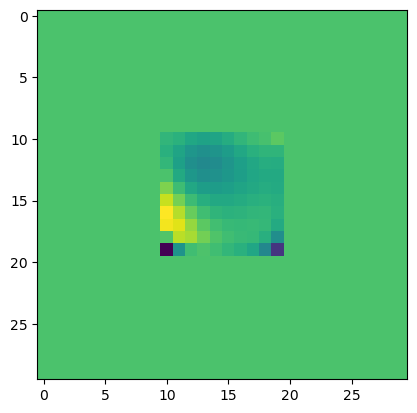

In [58]:
plt.imshow(masked_map[:,:,0])

In [ ]:
#Let's try different guidance levels sequentiall first.
count=0
for i in tqdm(range(len(heatmaps[0]))):
    plt.clf()
    fig=plt.figure(0, (7,7))
    
    for j, cfg_scale in enumerate(cfg_scales):
        # heatmap_norm=torch.nn.functional.normalize(heatmaps[j][i], p=2, dim=1)
        heatmap_norm=heatmaps[j][i] #*heatmap_mask
        #plt.quiver(grid[:,0], grid[:,1], -heatmap_norm[:,0], -heatmap_norm[:,1], alpha=0.2,  scale=40, color='c')

        # heatmap_norm=torch.nn.functional.normalize(unconditioned_heatmaps[j][i], p=2, dim=1)
        heatmap_norm=unconditioned_heatmaps[j][i] #*heatmap_mask
        #plt.quiver(grid[:,0], grid[:,1], -heatmap_norm[:,0], -heatmap_norm[:,1], alpha=0.2,  scale=40, color='#777777')

        # heatmap_norm=torch.nn.functional.normalize(conditioned_heatmaps[j][i], p=2, dim=1)
        heatmap_norm=conditioned_heatmaps[j][i] #*heatmap_mask
        #plt.quiver(grid[:,0], grid[:,1], -heatmap_norm[:,0], -heatmap_norm[:,1], alpha=0.2,  scale=40, color='m')

        for k in range(24): #Just do a subset of trajetories
            # plt.plot(xt_history[j][np.maximum(i-10, 0):i+1,k,0], xt_history[j][np.maximum(i-10, 0):i+1,k,1], '-', alpha=0.2, color=tuple(colors[c]))
            plt.plot(xt_history[j][:i+1,k,0], xt_history[j][:i+1,k,1], '-', alpha=np.clip(cfg_scale/10, 0.1, 1), color=colors24[k])
            plt.scatter(xt_history[j][i,k,0], xt_history[j][i,k,1], alpha=0.7, s=8, c=colors24[k])

    viz_bounds=1.8
    plt.xlim([-viz_bounds, viz_bounds]);  plt.ylim([-viz_bounds, viz_bounds])
    plt.savefig(save_dir/(str(count)+'.png'), dpi=200)
    count+=1

In [25]:
x, labels = next(iter(loader))
x=x.cpu().numpy()

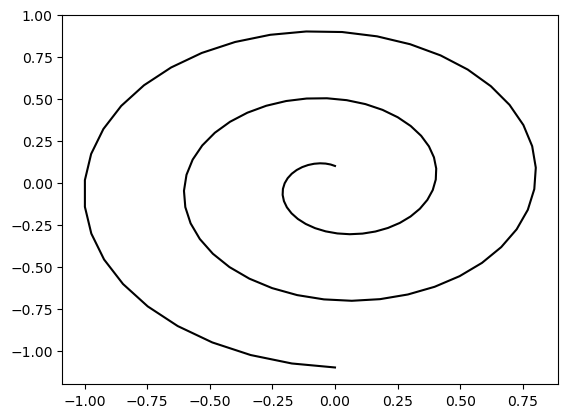

In [36]:
data_raw=np.array([o[0].numpy() for o in dataset.data])
plt.plot(data_raw[:,0], data_raw[:,1], c='k')

array([[-4.37113901e-09,  1.00000001e-01],
       [-1.73961129e-02,  1.08718030e-01],
       [-3.75070609e-02,  1.14200465e-01],
       [-5.97083271e-02,  1.15817957e-01],
       [-8.32466632e-02,  1.13063194e-01],
       [-1.07264087e-01,  1.05575509e-01],
       [-1.30825862e-01,  9.31606367e-02],
       [-1.52952462e-01,  7.58053213e-02],
       [-1.72654063e-01,  5.36855944e-02],
       [-1.88965932e-01,  2.71691717e-02],
       [-2.00984806e-01, -3.18921427e-03],
       [-2.07903862e-01, -3.66590731e-02],
       [-2.09045634e-01, -7.23514259e-02],
       [-2.03891739e-01, -1.09242499e-01],
       [-1.92108184e-01, -1.46202713e-01],
       [-1.73565313e-01, -1.82030112e-01],
       [-1.48352027e-01, -2.15487093e-01],
       [-1.16782703e-01, -2.45340616e-01],
       [-7.93973282e-02, -2.70402580e-01],
       [-3.69547792e-02, -2.89570630e-01],
       [ 9.58241336e-03, -3.01868141e-01],
       [ 5.90693615e-02, -3.06480795e-01],
       [ 1.10206477e-01, -3.02789837e-01],
       [ 1.

In [34]:
# dataset.data

[(tensor([-4.3711e-09,  1.0000e-01]), 0),
 (tensor([-0.0174,  0.1087]), 0),
 (tensor([-0.0375,  0.1142]), 0),
 (tensor([-0.0597,  0.1158]), 0),
 (tensor([-0.0832,  0.1131]), 0),
 (tensor([-0.1073,  0.1056]), 0),
 (tensor([-0.1308,  0.0932]), 0),
 (tensor([-0.1530,  0.0758]), 0),
 (tensor([-0.1727,  0.0537]), 0),
 (tensor([-0.1890,  0.0272]), 0),
 (tensor([-0.2010, -0.0032]), 0),
 (tensor([-0.2079, -0.0367]), 0),
 (tensor([-0.2090, -0.0724]), 0),
 (tensor([-0.2039, -0.1092]), 0),
 (tensor([-0.1921, -0.1462]), 0),
 (tensor([-0.1736, -0.1820]), 0),
 (tensor([-0.1484, -0.2155]), 0),
 (tensor([-0.1168, -0.2453]), 0),
 (tensor([-0.0794, -0.2704]), 0),
 (tensor([-0.0370, -0.2896]), 0),
 (tensor([ 0.0096, -0.3019]), 0),
 (tensor([ 0.0591, -0.3065]), 0),
 (tensor([ 0.1102, -0.3028]), 0),
 (tensor([ 0.1616, -0.2904]), 0),
 (tensor([ 0.2117, -0.2692]), 0),
 (tensor([ 0.2590, -0.2392]), 0),
 (tensor([ 0.3019, -0.2009]), 0),
 (tensor([ 0.3390, -0.1548]), 0),
 (tensor([ 0.3690, -0.1020]), 0),
 (tens